# Projects Analysis  
### QGI: Conner Wurth   
### October 2022


1. Read in summer Projects attendees that have been matched with Acts ID (in seperate Python script)   
***
2. Run through involvement queries
    i. Compare to non-projects Attendees
    ii. Compare against Historical?
***
3. Place all data into master table  
***

In [1]:
#Import needed libraries
import time
import datetime
import pymysql
import xlsxwriter
import smtplib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import numpy as np
from datetime import datetime, timedelta
import dateutil.parser
import pymysql.cursors
import psycopg2 #postgres query
from sshtunnel import SSHTunnelForwarder
from dotenv import load_dotenv
import random
import seaborn as sns

In [2]:
#set argument parameters
args = {}
#get dropbox
filestringstart = 'C:/Users/'
load_dotenv()
firstname = os.getenv("FIRST_NAME")
lastname = os.getenv("LAST_NAME")

acts_IP = os.getenv("POSTGRES_IP")
acts_ssh_user = os.getenv("POSTGRES_SSH_USERNAME")
ssh_key_path=os.getenv("POSTGRES_SSH_KEY_PATH")
acts_address = os.getenv("POSTGRES_SERVER_ADDRESS")

#PostGres custom fields
acts_user = os.getenv("POSTGRES_USERNAME")
acts_password = os.getenv("POSTGRES_PASSWORD")
acts_database_name = os.getenv("POSTGRES_DATABASE_NAME")


dropbox = filestringstart +  firstname + '.' + lastname + '/' + 'Dropbox/'
os.chdir(dropbox)
def add3months(x):
    if (x.month == 9 and x.day >= 15) or (x.month > 9) or (x.month == 1 and x.day < 15) or (x.month == 2 and x.day >= 15) or (x.month > 2 and x.month <9):
        if(x.month == 12 and x.day >=15):
            x = x + timedelta(31 - x.day + 14)
        elif (x.month == 1 and x.day < 15):
            x = x + timedelta(14 - x.day)
        elif (x.month == 9 and x.day >= 15) or (x.month > 9):
            x = x + timedelta(30)
        elif (x.month == 2 and x.day >= 15) or (x.month >2 and x.month <5) or (x.month == 5 and x.day < 15):
            x = x + timedelta(109)
        elif (x.month == 5):
            x = x + timedelta(109 - x.day + 15)
        elif (x.month == 6):
            x = x + timedelta(109 - 16 - x.day)
        elif (x.month == 7):
            x = x + timedelta(109 - 46 - x.day)
        elif (x.month == 8):
            x = x + timedelta(109 - 77 - x.day)
    y = x + timedelta(90) + timedelta(2) #3 months plus 2 days to get to end of retreat 
    y= y.strftime("%Y-%m-%d")
    return y

def read_data(files, location = 'Growth\\Data Analysis\\Event Analysis\\Retreats\\Attendees\\'):
    if type(files) == str:
        try:
            data = pd.read_csv(location + files, parse_dates = ['Start'])
        except:
            print('File Read Unsuccessful')
    else:
        try:
            for i, file in enumerate(files):
                data_part = pd.read_csv(location + file, parse_dates = ['Start'])
                if i ==0:
                    data = data_part.copy()
                else:
                    data = pd.concat([data_part, data], ignore_index = True, axis = 0)
        except:
            print('File Read Unsuccessful')
    return data
                
all_data = read_data(['FY22_Retreats_full_data.csv','FY21_Retreats_full_data.csv','FY20_Retreats_full_data.csv','FY19_Retreats_full_data.csv','FY18_Retreats_full_data.csv', 'FY17_Retreats_full_data.csv', 'FY16_Retreats_full_data.csv'])

all_data['End'] = all_data['Start'].apply(lambda x: add3months(x))
all_data['End']

0       2016-02-01
1       2016-02-01
2       2016-02-01
3       2016-02-01
4       2016-02-01
           ...    
4839    2022-10-27
4840    2022-10-27
4841    2022-10-27
4842    2022-10-27
4843    2022-10-27
Name: End, Length: 4844, dtype: object

In [3]:
all_data['Type'] = np.where(all_data['Event'].str.contains('Fath'), "Fathers House", np.where(all_data['Event'].str.contains('Boot'), 'Bootcamp', np.where(all_data['Event'].str.contains('Disciple'), 'Disciple', 'Other')))

In [4]:
all_data['Type']




#all_data[all_data['Type'] == 'Other']#['Start'].unique()

0       Fathers House
1       Fathers House
2       Fathers House
3       Fathers House
4       Fathers House
            ...      
4839    Fathers House
4840    Fathers House
4841    Fathers House
4842    Fathers House
4843    Fathers House
Name: Type, Length: 4844, dtype: object

In [5]:
# #2021
# #data_subset = data[data['Event'].str.contains('2021')]
# data_2020 = data[data['Start'] == '2020-06-01']
# data_2021 = data[data['Start'] == '2021-06-01']
# #greek_data = data[data['FOCUS Greek'] == 'Yes']
# greek_data_2020 = data_2020[data_2020['FOCUS Greek'] == 'Yes']
# greek_data_2021 = data_2021[data_2021['FOCUS Greek'] == 'Yes']
# non_greek_data_2020 = data_2020[data_2020['FOCUS Greek'] == 'No']
# non_greek_data_2021 = data_2021[data_2021['FOCUS Greek'] == 'No']
# male_data_2020 = data_2020[data_2020['Gender'] == 'Female']
# male_data_2021 = data_2021[data_2021['Gender'] == 'Female']


# greek_data_2020

# data_subset = male_data_2021.copy()
# retreats_students_at_FOCUS_campuses = len(data_subset)
# #data_subset
# len(male_data_2021)
all_data

Confirmation #   best_id  \
0            FY16_1   57933.0   
1          FY16_102   63006.0   
2          FY16_106   81293.0   
3          FY16_108   80422.0   
4          FY16_110   16574.0   
...             ...       ...   
4839       FY22_398  185949.0   
4840       FY22_400  184599.0   
4841       FY22_395  242196.0   
4842       FY22_397  242184.0   
4843       FY22_375  135377.0   

                                                 Event      Start  \
0     The Father's House (Georgia - October 2-4, 2015) 2015-10-02   
1     The Father's House (Georgia - October 2-4, 2015) 2015-10-02   
2     The Father's House (Georgia - October 2-4, 2015) 2015-10-02   
3     The Father's House (Georgia - October 2-4, 2015) 2015-10-02   
4     The Father's House (Georgia - October 2-4, 2015) 2015-10-02   
...                                                ...        ...   
4839            Pittsburgh Father's House (April 9-11) 2022-04-09   
4840            Pittsburgh Father's House (April 9-11) 2022-04-09   
4841      National Virtual Father's House (April 9-11) 2022-04-09   
4842      National Virtual Father's House (April 9-11) 2022-04-09   
4843      National Virtual Father's House (April 9-11) 2022-04-09   

               University Name         End           Type  
0                          NaN  2016-02-01  Fathers House  
1                          NaN  2016-02-01  Fathers House  
2                          NaN  2016-02-01  Fathers House  
3                          NaN  2016-02-01  Fathers House  
4                          NaN  2016-02-01  Fathers House  
...                        ...         ...            ...  
4839  University of Pittsburgh  2022-10-27  Fathers House  
4840  University of Pittsburgh  2022-10-27  Fathers House  
4841    University of Maryland  2022-10-27  Fathers House  
4842    University of Maryland  2022-10-27  Fathers House  
4843          Drake University  2022-10-27  Fathers House  

[4844 rows x 7 columns]

In [6]:
#Initialize SSH Tunnel Fields
acts_IP = os.getenv("POSTGRES_IP")
acts_ssh_user = os.getenv("POSTGRES_SSH_USERNAME")
ssh_key_path=os.getenv("POSTGRES_SSH_KEY_PATH")
acts_address = os.getenv("POSTGRES_SERVER_ADDRESS")

#PostGres custom fields
acts_user = os.getenv("POSTGRES_USERNAME")
acts_password = os.getenv("POSTGRES_PASSWORD")
acts_database_name = os.getenv("POSTGRES_DATABASE_NAME")

In [7]:
tunnel = SSHTunnelForwarder(
    (acts_IP, 22), #Remote server IP and SSH port
    ssh_username = acts_ssh_user,
    ssh_private_key = ssh_key_path,
    remote_bind_address=(acts_address, 5432),
    local_bind_address=('localhost',random.randrange(1025,65535)), #any available port will do
        )
def openconnection():
    global connection
    connection = psycopg2.connect(host=tunnel.local_bind_host,
                                port=tunnel.local_bind_port,
                                 user=acts_user,
                                 password=acts_password,
                                 database=acts_database_name)

In [10]:
###
#Simple query test to see if connection can be established:
###
sql= """
Select P.id, P.gender_id
from people as P
"""
tunnel.start()
openconnection()
try:
    with connection.cursor() as cursor:
        all_people = pd.read_sql(sql, params=args, con=connection)   
finally:
    connection.close()
tunnel.stop()

all_people['gender'] = np.where(all_people['gender_id'] == 12, 'Male', 'Female')

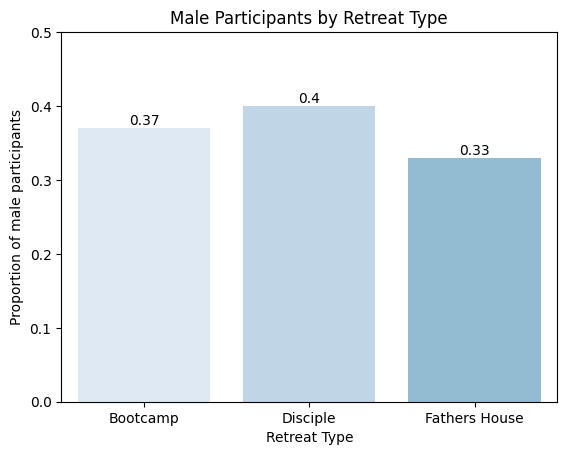

By a significant but only marginal difference, mmen are less likely to attend a Father's House retreat than a Spritual Impact Boorcamp


In [71]:
all_gendered_data = all_people.merge(all_data, left_on = 'id', right_on = 'best_id', how = 'inner')

def display_data_normalized(normalize = True):
    df = all_gendered_data.groupby('Type')['gender'].value_counts(normalize = normalize).reset_index(name = 'Count')
    df['Count'] = round(df['Count'],2)
    df = df[df['gender'] == 'Male']
    df = df[df['Type'] != 'Other']
    sns.set_palette("Blues")
    ax = sns.barplot(x = 'Type', y= 'Count', data = df)
    
    for i in ax.containers:
        ax.bar_label(i,)
    plt.ylim([0,.5])
    plt.title("Male Participants by Retreat Type")
    plt.ylabel('Proportion of male participants')
    plt.xlabel('Retreat Type')
    plt.show()

display_data_normalized(normalize = True)
#display_data_normalized(False)
#len(all_gendered_data)
print("""By a significant but only marginal difference, mmen are less likely to attend a Father's House retreat than a Spritual Impact Boorcamp""")


In [172]:
#What Stage of Disciple Funnel Do they Enter? Is it different from women?
involvement_query = """
Select P.id, %(start_date)s as start_date,
case
    when max(Dtype.name) in ('Spiritual Multiplier', 'Disciple Maker') then max(Dtype.name)
    when max(BSA2.id) is not null then 'SLBS'
    when max(Dtype.name) is not null then max(Dtype.name)
    when max(BSP_count) >= 4 then 'BSPx4'
    when max(BSP_count) >= 1 then 'BSPx1'
    else 'No Acts Involvement' end as involvement
from people as P
join person_location_roles as plr on plr.person_id=P.id
    and (plr.ended_at is null or plr.ended_at >= %(start_date)s)
    and plr.started_at <= %(start_date)s
    and plr.role_id in (13,16)
left join disciples as D on D.person_id=P.id
    and D.created_at <= %(start_date)s 
    and (D.ended_at is null or D.ended_at >= %(start_date)s)
left join list_items as Dtype on Dtype.id=D.disciple_type_id
left join 
    (Select jsonb_array_elements_text(BSA.participants->'attended')::int as attendee,
    count(distinct BSA.id) as BSP_count
    from bible_study_attendances as BSA
    where BSA.met_at <= %(start_date)s
    group by attendee
    ) as bstudy on bstudy.attendee=P.id
left join bible_study_leaders as bsl on bsl.person_id=P.id
    and bsl.created_at <= %(start_date)s
left join bible_study_attendances as BSA2 on BSA2.bible_study_id = bsl.bible_study_id
    and BSL.created_at - interval '8 hours' <= BSA2.submitted_at
    and (BSL.deleted_at is null or BSL.deleted_at >= %(start_date)s)
    and date(BSA2.met_at) <= %(start_date)s
group by P.id
"""
#Start data with nulls
#all_gendered_data['start_involvment'] = np.NaN



fulldship_data = pd.DataFrame()
tunnel.start()
openconnection()
try:
    with connection.cursor() as cursor:
        for i, start_date in enumerate(all_gendered_data.Start.unique()):
            print(len(all_gendered_data.Start.unique()) - i)
            args['start_date'] = start_date.astype(str)
            involvement_table = pd.read_sql(involvement_query, params=args, con=connection)
            involvement_table['start_date'] = pd.to_datetime(involvement_table['start_date'])
            dship_data = all_gendered_data.merge(involvement_table, left_on = ['id','Start'], right_on = ['id', 'start_date'], how = 'inner')
            fulldship_data = pd.concat([fulldship_data, dship_data], axis = 0)
finally:
    connection.close()
tunnel.stop()
    
 
    
    #Populate
    


#Dynamically populate start_date based on event_start_date

    #args['start_date'] = 

#Which Retreat Does a Better Job?

###Do Father's House, Spiritual Impact Bootcamp, or Way of the Disciple




89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


0       2016-04-30
1       2016-02-22
2       2017-10-25
3       2016-02-29
4       2017-03-20
           ...    
4839    2022-10-19
4840    2022-03-14
4841    2022-10-26
4842    2021-09-22
4843    2022-03-14
Name: End, Length: 4844, dtype: object

In [199]:
involvement_query2 = """
Select P.id, %(end_date)s as end_date,
case
    when max(Dtype.name) in ('Spiritual Multiplier', 'Disciple Maker') then max(Dtype.name)
    when max(BSA2.id) is not null then 'SLBS'
    when max(Dtype.name) is not null then max(Dtype.name)
    when max(BSP_count) >= 4 then 'BSPx4'
    when max(BSP_count) >= 1 then 'BSPx1'
    else 'No Acts Involvement' end as involvement
from people as P
join person_location_roles as plr on plr.person_id=P.id
    and (plr.ended_at is null or plr.ended_at >= %(end_date)s)
    and plr.started_at <= %(end_date)s
    and plr.role_id in (13,16)
    and plr.school_year_id in (4,5,6,7)
left join disciples as D on D.person_id=P.id
    and D.created_at <= %(end_date)s 
    and (D.ended_at is null or D.ended_at >= %(end_date)s)
left join list_items as Dtype on Dtype.id=D.disciple_type_id
left join 
    (Select jsonb_array_elements_text(BSA.participants->'attended')::int as attendee,
    count(distinct BSA.id) as BSP_count
    from bible_study_attendances as BSA
    where BSA.met_at <= %(end_date)s
    group by attendee
    ) as bstudy on bstudy.attendee=P.id
left join bible_study_leaders as bsl on bsl.person_id=P.id
    and bsl.created_at <= %(end_date)s
left join bible_study_attendances as BSA2 on BSA2.bible_study_id = bsl.bible_study_id
    and BSL.created_at - interval '8 hours' <= BSA2.submitted_at
    and (BSL.deleted_at is null or BSL.deleted_at >= %(end_date)s)
    and date(BSA2.met_at) <= %(end_date)s
group by P.id
"""
#Start data with nulls
#all_gendered_data['start_involvment'] = np.NaN



fulldship_data_post = pd.DataFrame()
tunnel.start()
openconnection()
try:
    with connection.cursor() as cursor:
        for i, end_date in enumerate(all_gendered_data.End.unique()):
            print(len(all_gendered_data.Start.unique()) - i)
            args['end_date'] = end_date#.astype(str)
            involvement_table = pd.read_sql(involvement_query2, params=args, con=connection)
            #involvement_table['end_date'] = pd.to_datetime(involvement_table['end_date'])
            post_dship_data = all_gendered_data.merge(involvement_table, left_on = ['id','End'], right_on = ['id', 'end_date'], how = 'inner')
            fulldship_data_post = pd.concat([fulldship_data_post, post_dship_data], axis = 0)
finally:
    connection.close()
tunnel.stop()

89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [200]:
#Sort by Acts Involvement

#fulldship_data_post = fulldship_data_post.drop_duplicates(subset = ['best_id', 'End'])





display(len(all_gendered_data))

display(len(fulldship_data_post))#, 'No Match'

fulldship_data_post.to_csv('Retreat Involvement after retreat.csv')

4844

4392

In [9]:
#fulldship_data_post['post_involvement'] = fulldship_data_post['involvement']


fulldship_data_post['involvement']




0              Disciple Maker
1                       BSPx4
2       Commissioned Disciple
3                        SLBS
4       Commissioned Disciple
                ...          
4387      No Acts Involvement
4388                     SLBS
4389                     SLBS
4390         Growing Disciple
4391                    BSPx4
Name: involvement, Length: 4392, dtype: object

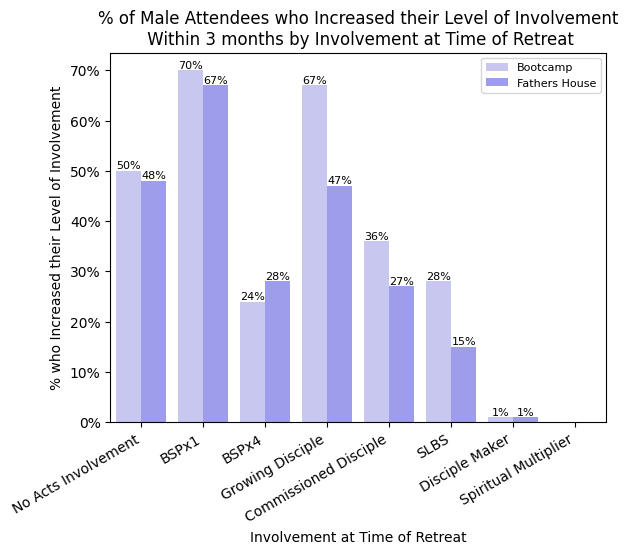

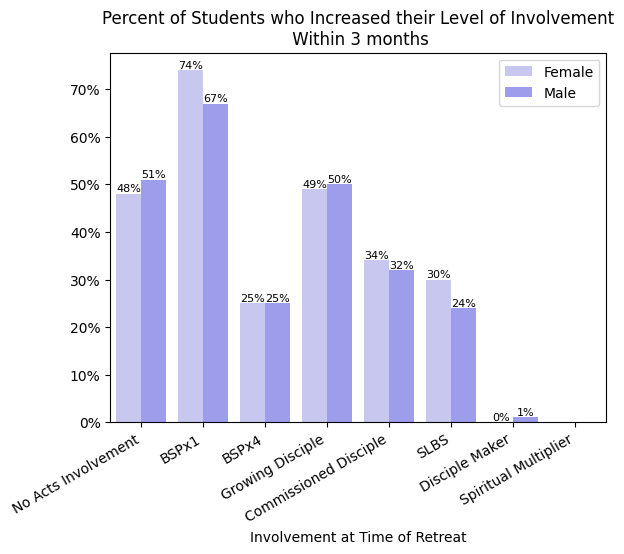

In [131]:
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

#Most 
# fulldship_data = pd.read_csv('Growth/Data Analysis/Event Analysis/Retreats/Attendees/Retreat Involvement at time of retreat.csv')
fulldship_data_pre = pd.read_csv('Retreat Involvement at time of retreat.csv')
fulldship_data_post= pd.read_csv('Retreat Involvement after retreat.csv')

fulldship_data = fulldship_data_pre.merge(fulldship_data_post[['Confirmation #','involvement']], on = 'Confirmation #', how = 'inner', suffixes = ['_pre','_post'])

involvement_order = ['No Acts Involvement', 'BSPx1', 'BSPx4', 'Growing Disciple', 'Commissioned Disciple', 'SLBS', 'Disciple Maker', 'Spiritual Multiplier']
involvement_rank = list(range(len(involvement_order)))
involvement_dict = dict(zip(involvement_order, involvement_rank))

fulldship_data[['involvement_pre_num', 'involvement_post_num']] = fulldship_data[['involvement_pre', 'involvement_post']].replace(involvement_dict)


fulldship_data['growth'] = np.where(fulldship_data['involvement_pre_num'] < fulldship_data['involvement_post_num'], 1, 0)

new_data = fulldship_data[fulldship_data['gender'] == 'Male']

formal_df = new_data.groupby(['involvement_pre',  'Type'])['growth'].value_counts(normalize = True).sort_index().reset_index(name = 'Count')

formal_df = formal_df[formal_df['growth'] == 1].drop('growth', axis = 1)

formal_df['Count'] = formal_df['Count']*100

formal_df = formal_df[formal_df['Type'].isin(['Bootcamp', 'Fathers House'])]#.drop('growth', axis = 1)


formal_df['Count'] = round(formal_df['Count'], 0)

ax = sns.barplot(x = 'involvement_pre', y = 'Count', hue = 'Type', data = formal_df, order = involvement_order)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

for i in ax.containers:
        ax.bar_label(i,fontsize=8, fmt='%.f%%')
        
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
#ax.tick_params(labelsize=5) 
plt.xlabel("Involvement at Time of Retreat")
plt.ylabel('% who Increased their Level of Involvement')

plt.legend(loc='upper right', fontsize=8)
plt.title("% of Male Attendees who Increased their Level of Involvement\n Within 3 months by Involvement at Time of Retreat")
sns.reset_defaults()
sns.set_palette(sns.light_palette("Blue", reverse=False)[1:5])
plt.show()

formal_df = fulldship_data.groupby(['involvement_pre',  'gender'])['growth'].value_counts(normalize = True).sort_index().reset_index(name = 'Count')

formal_df = formal_df[formal_df['growth'] == 1].drop('growth', axis = 1)

formal_df['Count'] = formal_df['Count']*100

formal_df['Count'] = round(formal_df['Count'], 0)

ax = sns.barplot(x = 'involvement_pre', y = 'Count', hue = 'gender', data = formal_df, order = involvement_order)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

for i in ax.containers:
        ax.bar_label(i,fontsize=8, fmt='%.f%%')
plt.xlabel(None)
plt.legend(loc='upper right')
sns.reset_defaults()
plt.title("Percent of Students who Increased their Level of Involvement\n Within 3 months")
plt.xlabel("Involvement at Time of Retreat")
plt.ylabel(None)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
sns.set_palette(sns.light_palette("Blue", reverse=False)[1:5])
plt.show()


#sns.palplot(sns.cubehelix_palette(8, start=2))
#Barely involved to Disiple
# 29%

#Barely involved men are more likely to become Disciples then men who are regular BSPs

In [12]:
fulldship_data

Unnamed: 0      id  gender_id  gender Confirmation #   best_id  \
0              0    1944       13.0  Female       FY16_640    1944.0   
1              2   15954       13.0  Female       FY16_650   15954.0   
2              3   18434       13.0  Female       FY16_635   18434.0   
3              4   21802       12.0    Male       FY16_556   21802.0   
4              5   40877       13.0  Female       FY16_656   40877.0   
...          ...     ...        ...     ...            ...       ...   
4394           4  186112       13.0  Female       FY22_389  186112.0   
4395           0  191687       13.0  Female         FY22_2  191687.0   
4396           1  191663       12.0    Male         FY22_1  191663.0   
4397           2  196133       13.0  Female         FY22_3  196133.0   
4398           3  206989       13.0  Female         FY22_4  206989.0   

                                                  Event       Start  \
0     Spiritual Impact Boot-camp (Georgia - January ...  2016-01-29   
1     Spiritual Impact Boot-camp (Georgia - January ...  2016-01-29   
2     Spiritual Impact Boot-camp (Georgia - January ...  2016-01-29   
3     Spiritual Impact Boot-camp (Georgia - January ...  2016-01-29   
4     Spiritual Impact Boot-camp (Georgia - January ...  2016-01-29   
...                                                 ...         ...   
4394             Pittsburgh Father's House (April 9-11)  2022-04-09   
4395      Kentucky Father's House Retreat (March 25-27)  2022-03-25   
4396      Kentucky Father's House Retreat (March 25-27)  2022-03-25   
4397      Kentucky Father's House Retreat (March 25-27)  2022-03-25   
4398      Kentucky Father's House Retreat (March 25-27)  2022-03-25   

                  University Name   3mo_Later           Type  start_date  \
0                             NaN  2016-04-30       Bootcamp  2016-01-29   
1                             NaN  2016-04-30       Bootcamp  2016-01-29   
2                             NaN  2016-04-30       Bootcamp  2016-01-29   
3                             NaN  2016-04-30       Bootcamp  2016-01-29   
4                             NaN  2016-04-30       Bootcamp  2016-01-29   
...                           ...         ...            ...         ...   
4394     Saint Francis University  2022-10-27  Fathers House  2022-04-09   
4395       University of Kentucky  2022-10-12  Fathers House  2022-03-25   
4396       University of Kentucky  2022-10-12  Fathers House  2022-03-25   
4397  Western Kentucky University  2022-10-12  Fathers House  2022-03-25   
4398  Western Kentucky University  2022-10-12  Fathers House  2022-03-25   

            involvement_pre       involvement_post  involvement_pre_num  \
0            Disciple Maker         Disciple Maker                    6   
1                     BSPx4                  BSPx4                    2   
2     Commissioned Disciple  Commissioned Disciple                    4   
3                      SLBS                   SLBS                    5   
4     Commissioned Disciple  Commissioned Disciple                    4   
...                     ...                    ...                  ...   
4394                   SLBS                   SLBS                    5   
4395                   SLBS                   SLBS                    5   
4396                   SLBS                   SLBS                    5   
4397       Growing Disciple       Growing Disciple                    3   
4398                  BSPx4                  BSPx4                    2   

      involvement_post_num  growth  
0                        6       0  
1                        2       0  
2                        4       0  
3                        5       0  
4                        4       0  
...                    ...     ...  
4394                     5       0  
4395                     5       0  
4396                     5       0  
4397                     3       0  
4398                     2       0  

[4399 rows x 17 columns]

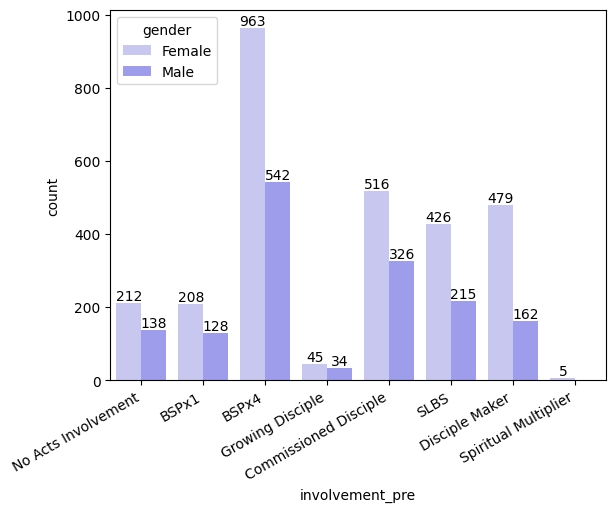

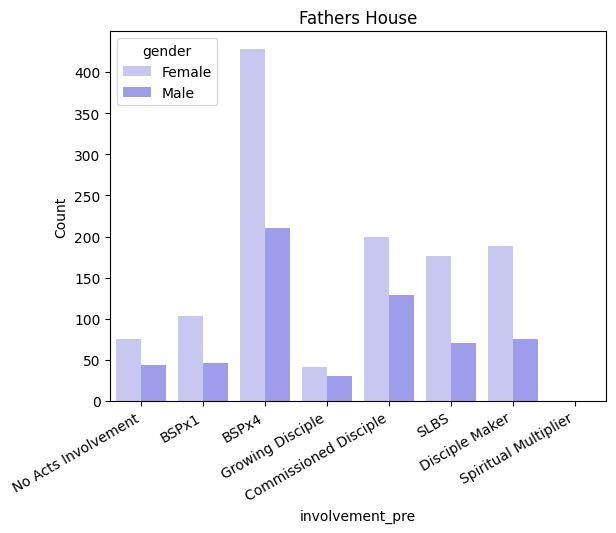

7


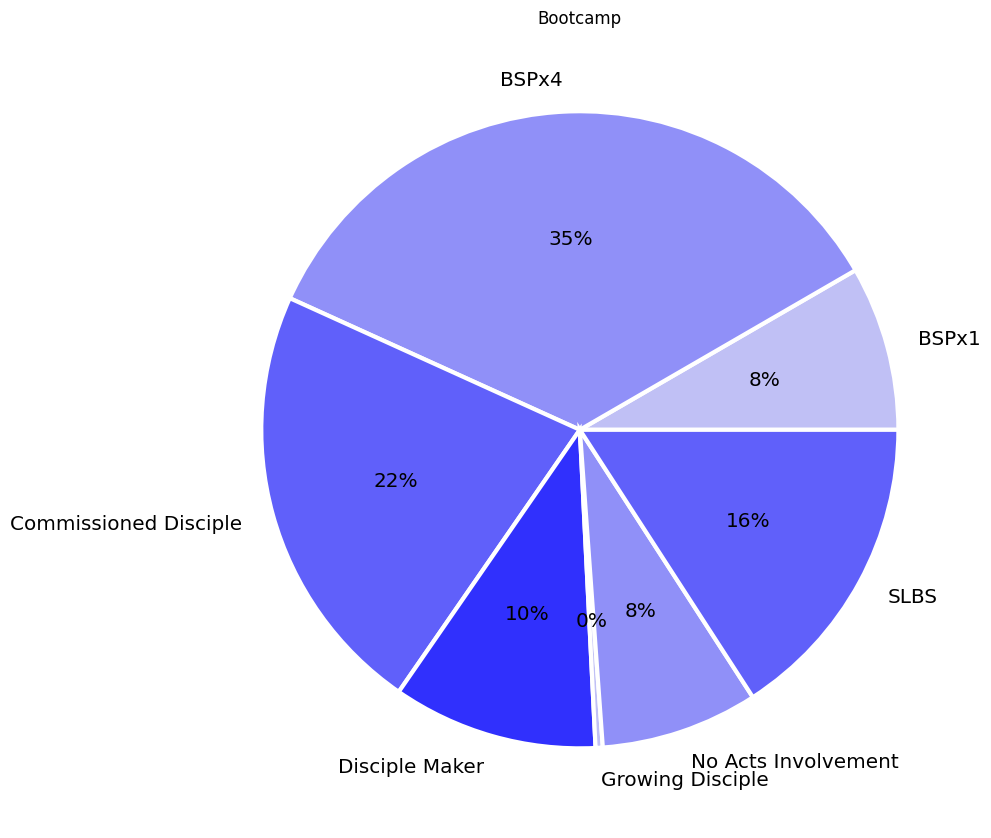

7


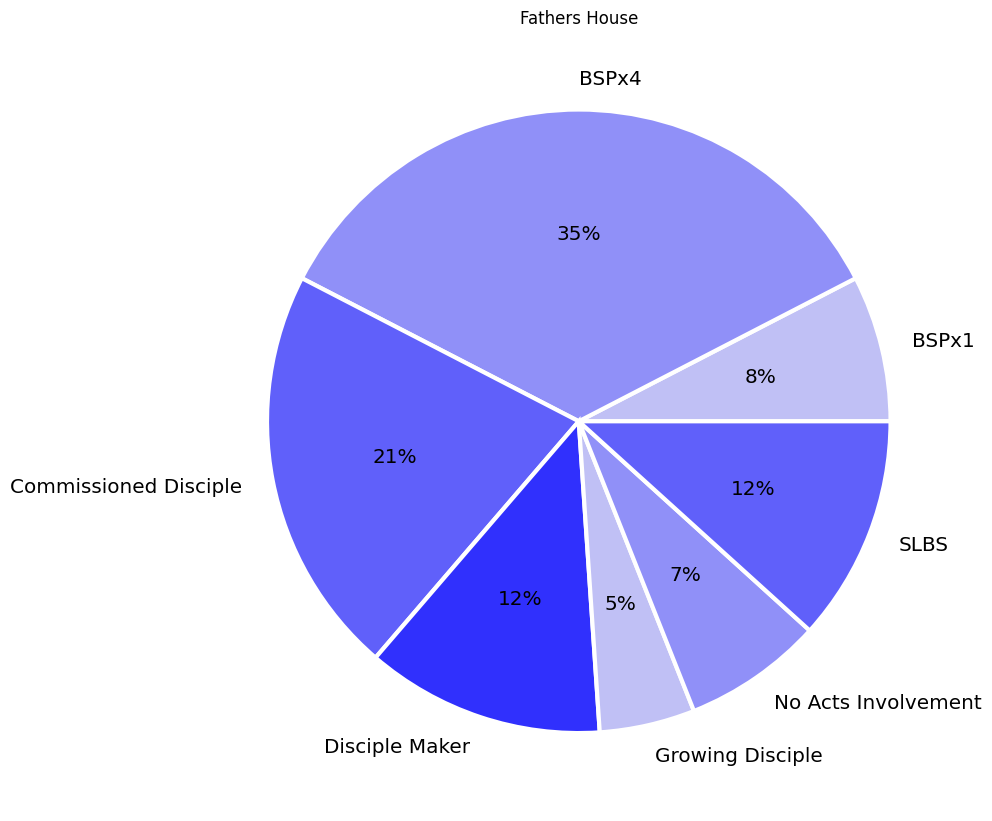

7


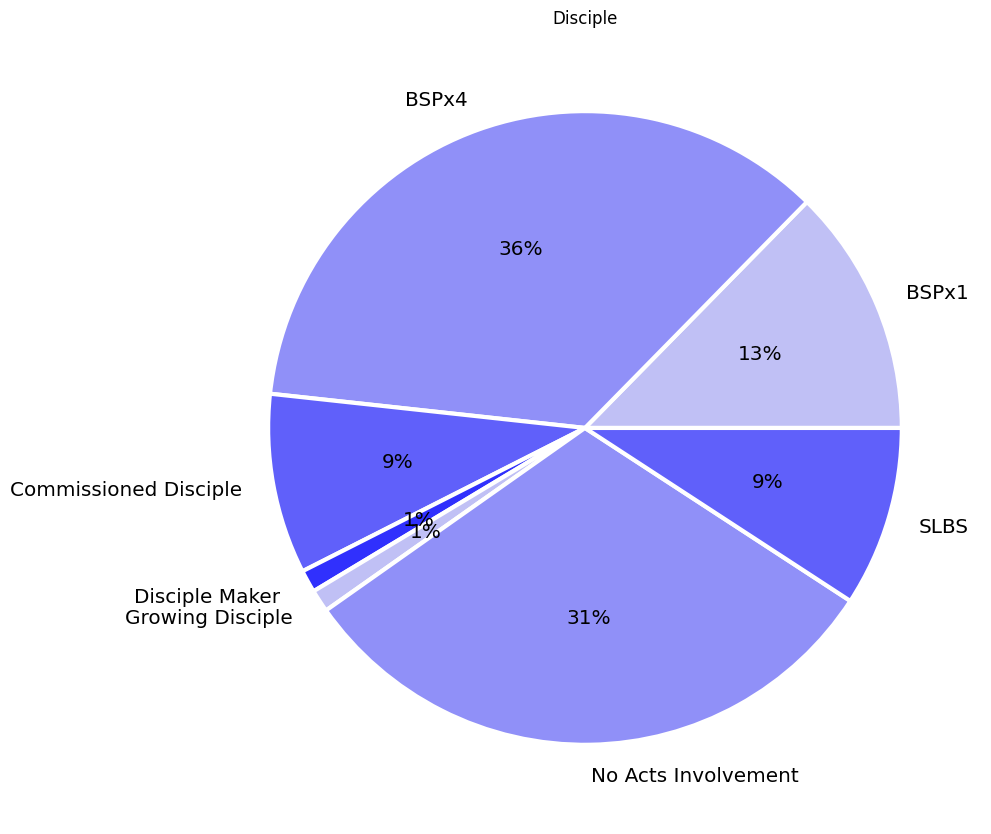

5


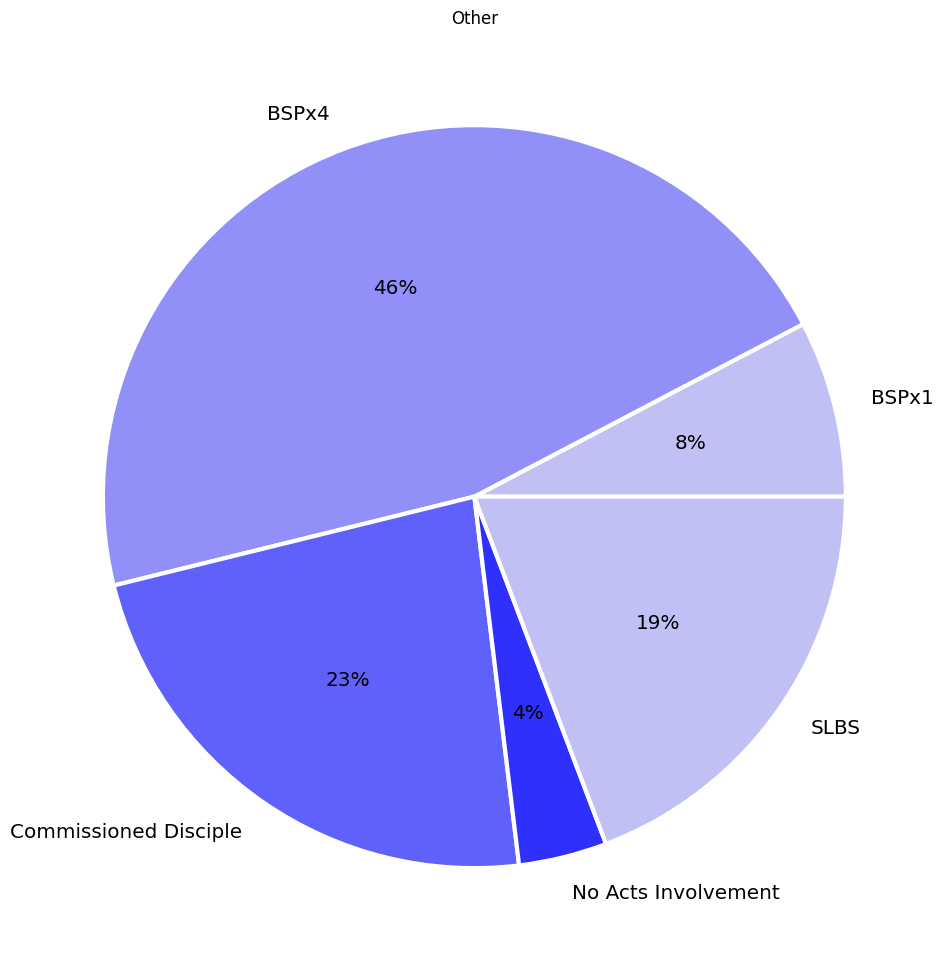

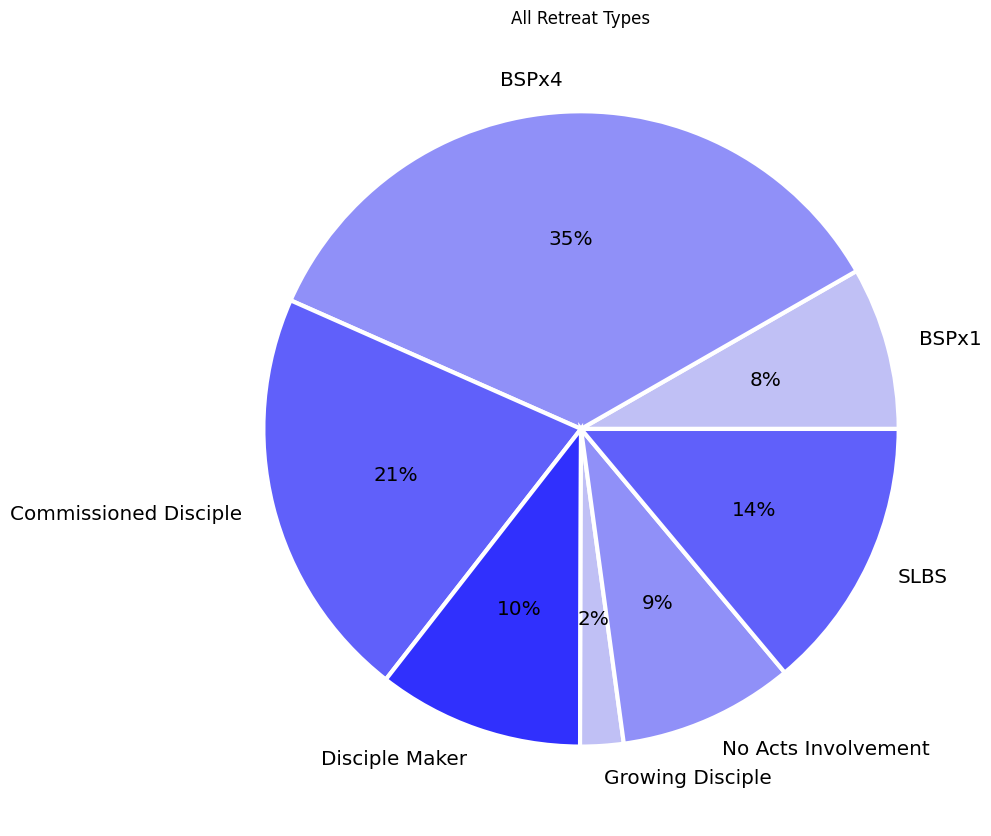

In [70]:
df = fulldship_data.groupby('gender')['involvement_pre'].value_counts(normalize = True).reset_index(name = 'Count')
df['Count'] = round(df['Count'],2)


involvement_order = ['No Acts Involvement', 'BSPx1', 'BSPx4', 'Growing Disciple', 'Commissioned Disciple', 'SLBS', 'Disciple Maker', 'Spiritual Multiplier']

ax = sns.countplot(x = 'involvement_pre', hue= 'gender', data = fulldship_data, order = involvement_order)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

for i in ax.containers:
        ax.bar_label(i,)
plt.show()
    
    
#Men & women are both about equally likely to be bible study participants as Disciples. 
#However, one might successfully argue that disciples are more likely to be known than non-disciples. 
#This would give the edge to Bible Study Attendees


df = fulldship_data.groupby(['gender', 'involvement_pre'])['Type'].value_counts(normalize = False).reset_index(name = 'Count')

# ax = sns.barplot(x = 'involvement', y = 'Count', hue= 'gender', data = df, order = involvement_order)
# plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plt.show()

df[df['Type'] == 'Fathers House']

ax = sns.barplot(x = 'involvement_pre', y = 'Count', hue= 'gender', data = df[df['Type'] == 'Fathers House'], order = involvement_order)
plt.title('Fathers House')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


df = df[df['gender'] == 'Male']


for typ in df['Type'].unique():
    fig, ax = plt.subplots(figsize=(10, 10))
    print(len(df[df['Type'] == typ]['involvement_pre']))
    ax.pie(df[df['Type'] == typ]['Count'], labels = df[df['Type'] == typ]['involvement_pre'], autopct='%.0f%%',
           wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
           textprops={'size': 'x-large'}, #explode=(0, .1, 0, 0, 0, 0)
          )
    plt.tight_layout()
    
#     plt.pie(df[df['Type'] == typ]['Count'], labels = df[df['Type'] == typ]['involvement'], autopct='%.0f%%')
    plt.title(typ) 
    plt.show()


#There are no major differences for men on which retreat they attend according to invovlement

df = df.groupby('involvement_pre')['Count'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(df['Count'], labels = df['involvement_pre'], autopct='%.0f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'}, #explode=(0, .1, 0, 0, 0, 0)
      )
plt.tight_layout()

#     plt.pie(df[df['Type'] == typ]['Count'], labels = df[df['Type'] == typ]['involvement'], autopct='%.0f%%')
plt.title('All Retreat Types') 
plt.show()


#.plot()
# day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# ax = df.set_index(field).loc[day_order].plot(kind="bar", legend=False)

#x = ,y = 'involvement',df = fulldship_data

In [182]:
#Data cleaning
#Check total IDs and compare to those that have been matched with Acts IDs
retreats_attendees = fulldship_data
retreats_attendees['best_id'] = retreats_attendees['best_id'].astype('object')
retreats_attendees = retreats_attendees.dropna(subset = ['best_id'])
len_retreats_attendees = len(retreats_attendees)
print('Student retreat Attendees Who Have an Acts 2:47 ID: ', len_retreats_attendees)

Student retreat Attendees Who Have an Acts 2:47 ID:  4735


In [258]:
#Place ids in list to use as parameter in following query
ids = list(retreats_attendees['best_id'])

# greek_ids = list(greeks['id'])
# other_ids = list(non_greek_data_2021['best_id'])

## Summer Projects Before/After Queries

### Disciples at Start of projects Query:

In [ ]:
#I need to look at their initial involvement, and then look at their ending involvement

#Do the query again with final involvement - if they are no longer students, 
#or if they are now senior+, I should exclude them

In [259]:


### Disciples at start of projects
sql = """select P.id
            from people as P
            join person_location_roles as PLR on PLR.person_id=P.id 
                and PLR.started_at <= %(retreats_start)s 
                and (PLR.ended_at is null or PLR.ended_at >= %(retreats_start)s)
                and PLR.role_id in (13,16) 
                and plr.school_year_id not in (7,8,10,11)
            join location_relationships as LR on LR.location_id=PLR.location_id 
                and LR.parent_location_id not in (9343, 9337, 9335, 9344) 
                and LR.started_at <= %(three_month_end)s 
                and (LR.ended_at is null or LR.ended_at >= %(three_month_end)s)
            join disciples as D on D.person_id = P.id 
                and D.created_at <= %(retreats_start)s 
                and (D.ended_at is null or D.ended_at >= %(retreats_start)s)
                and D.disciple_type_id != 71
            join person_location_roles as PLR2 on PLR2.person_id=P.id 
                and PLR2.started_at <= %(three_month_end)s 
                and (PLR2.ended_at is null or PLR2.ended_at >= %(three_month_end)s)
                and PLR2.role_id in (13,16) 
                and PLR2.school_year_id not in (10,11)
            --Gender additions
            where P.gender_id = 12
            group by P.id
                """
tunnel.start()
openconnection()
try:
    with connection.cursor() as cursor:
        result = pd.read_sql(sql, params=args, con=connection)
        #split attendee and nonattendee
        nonattendee = result[~result['id'].isin(ids)]
        #nonattendee = nonattendee[~nonattendee['id'].isin(other_ids)]
        #nonattendee = nonattendee[nonattendee['id'].isin(greek_ids)]
        result = result[result['id'].isin(ids)]
        #get attendee info
        D_at_start_projects = len(result)
        print('Disciples at start of projects: ' , D_at_start_projects)
        #get nonattendee info
        nonattendee_D_at_start_projects = len(nonattendee)
        print('Nonattendee Disciples at start of projects: ' , nonattendee_D_at_start_projects)
        #Create Disciple lists for later
        Disciple_list = list(result['id'])
        Nonattendee_disciple_list = list(nonattendee['id'])
finally:
    connection.close()
tunnel.stop()

Disciples at start of projects:  48
Nonattendee Disciples at start of projects:  823


In [260]:
### BSPx4 conversion to D
sql = """Select bstudy.id as id, attendances from
        (select jsonb_array_elements_text(BSA.participants->'attended')::int as id, count(distinct BSA.id) as attendances
            from bible_study_attendances as BSA
            where BSA.met_at between %(spring_start)s and %(retreats_start)s
            group by jsonb_array_elements_text(BSA.participants->'attended')::int
            having count(distinct BSA.id) >= 4) as bstudy
            join person_location_roles as PLR on PLR.person_id=bstudy.id 
                and PLR.started_at <= %(retreats_start)s 
                and (PLR.ended_at is null or PLR.ended_at >= %(retreats_start)s)
                and PLR.role_id in (13,16) and PLR.school_year_id not in (7,8,10,11)
            join person_location_roles as PLR2 on PLR2.person_id=bstudy.id
                and PLR2.started_at <= %(three_month_end)s 
                and (PLR2.ended_at is null or PLR2.ended_at >= %(three_month_end)s)
                and PLR2.role_id in (13,16) 
                and PLR2.school_year_id not in (10,11)
            join location_relationships as LR on LR.location_id=PLR.location_id
                and LR.parent_location_id not in (9343, 9337, 9335, 9344) 
                and LR.started_at <= %(three_month_end)s 
                and (LR.ended_at is null or LR.ended_at >= %(three_month_end)s)
            --Gender additions
            join people as P on P.id=bstudy.id
            where P.gender_id = 12
            ---end of Gender Additions

    """
tunnel.start()
openconnection()
try:
    with connection.cursor() as cursor:
        result = pd.read_sql(sql, params=args, con=connection)
        #split attendee and nonateendee
        nonattendee = result[~result['id'].isin(ids)]
        nonattendee = nonattendee[~nonattendee['id'].isin(Nonattendee_disciple_list)]
#         nonattendee = nonattendee[~nonattendee['id'].isin(other_ids)]
#         nonattendee = nonattendee[nonattendee['id'].isin(greek_ids)]
        result = result[result['id'].isin(ids)]
        result = result[~result['id'].isin(Disciple_list)]
        #attendee info
        BSPx4_not_D_at_start_projects = len(result)
        BSPx4_not_D_at_start_retreats_list = list(result['id'])
        print('BSPx4 but not Disciples at start of projects: ' , BSPx4_not_D_at_start_projects)
        #nonattendee info        
        nonattendee_BSPx4_not_D_at_start_projects = len(nonattendee)
        nonattendee_BSPx4_not_D_at_start_retreats_list = list(nonattendee['id'])
        print('Nonattendee BSPx4 but not Disciples at start of projects: ' , nonattendee_BSPx4_not_D_at_start_projects)
        #deep dive info
        print('Deep Dive info')
        print('projects Average BSPs for BSPx4 but not Disciples at start of projects: ' , round(result['attendances'].mean(),2))
        print('Nonattendee Average BSPs for BSPx4 but not Disciples at start of projects: ' , round(nonattendee['attendances'].mean(),2))
finally:
    connection.close()
tunnel.stop()

BSPx4 but not Disciples at start of projects:  35
Nonattendee BSPx4 but not Disciples at start of projects:  3051
Deep Dive info
projects Average BSPs for BSPx4 but not Disciples at start of projects:  9.46
Nonattendee Average BSPs for BSPx4 but not Disciples at start of projects:  7.7


In [261]:
### BSPx4 conversion to D

sql = """select P.id
            from people as P
            join disciples as D on D.person_id = P.id 
            and D.created_at <= %(three_month_end)s 
            and (D.ended_at is null or D.ended_at >= %(retreats_start)s) 
            and D.disciple_type_id!= 71
            --Gender additions
            where P.gender_id = 12
            ---End of Gender Additions
            group by P.id
        """
tunnel.start()
openconnection()
try:
    with connection.cursor() as cursor:
        result = pd.read_sql(sql, params=args, con=connection)
        #split attendee and nonateendee
        nonattendee = result[result['id'].isin(nonattendee_BSPx4_not_D_at_start_retreats_list)]
#         nonattendee = nonattendee[~nonattendee['id'].isin(other_ids)]
#         nonattendee = nonattendee[nonattendee['id'].isin(greek_ids)]
        result = result[result['id'].isin(BSPx4_not_D_at_start_retreats_list)]
        #attendee info
        BSPx4_became_D_3_post = len(result)
        print('BSPx4 that became D in 3 months post projects: ' , BSPx4_became_D_3_post)
        #nonattendee info
        nonattendee_BSPx4_became_D_3_post = len(nonattendee)
        print('Nonattendee BSPx4 that became D in 3 months post projects: ' , nonattendee_BSPx4_became_D_3_post)
finally:
    connection.close()
tunnel.stop()

BSPx4 that became D in 3 months post projects:  7
Nonattendee BSPx4 that became D in 3 months post projects:  96


### D that hadn't led a BS before projects to SLBS post Summer Projects

In [262]:
#Note: This query does not specify >= 6 monthsindship
sql = """select P.id, 
            case when 
                min(BSA.met_at) between %(retreats_start)s and %(three_month_end)s 
                then P.id 
                end as d_became_slbs,
            case when 
                min(BSA.met_at) is null or min(BSA.met_at) >= %(retreats_start)s 
                then P.id 
                end as d_not_yet_slbs
            from people as P
            join disciples as D on D.person_id=P.id 
                and D.created_at <= %(retreats_start)s 
                and (D.ended_at is null or D.ended_at >= %(retreats_start)s) 
                and D.disciple_type_id!= 71
            left join bible_study_leaders as BSL on BSL.person_id=P.id
            left join bible_study_attendances as BSA on BSA.bible_study_id=BSL.bible_study_id 
                and BSL.created_at - interval '8 hours' <= BSA.submitted_at 
                and (BSL.deleted_at is null or BSL.deleted_at >= BSA.submitted_at)
                and BSA.cancelled = false
            join person_location_roles as PLR on PLR.person_id=P.id 
                and PLR.started_at <= %(retreats_start)s 
                and (PLR.ended_at is null or PLR.ended_at >= %(retreats_start)s)
                and PLR.role_id in (13,16) 
                and PLR.school_year_id not in (7,8,10,11)
            join location_relationships as LR on LR.location_id=PLR.location_id 
                and LR.parent_location_id not in (9343, 9337, 9335, 9344) 
                and LR.started_at <= %(three_month_end)s 
                and (LR.ended_at is null or LR.ended_at >= %(three_month_end)s)
            join person_location_roles as PLR2 on PLR2.person_id=P.id
                and PLR2.started_at <= %(three_month_end)s 
                and (PLR2.ended_at is null or PLR2.ended_at >= %(three_month_end)s)
                and PLR2.role_id in (13,16) 
                and PLR2.school_year_id not in (10,11)
            --Gender additions
            where P.gender_id = 12
            ---End of Gender Additions
            group by P.id"""
tunnel.start()
openconnection()
try:
    with connection.cursor() as cursor:
        result = pd.read_sql(sql, params=args, con=connection)
        #split attendee and non_attendee
        nonattendee = result[~result['id'].isin(ids)]
#         nonattendee = nonattendee[~nonattendee['id'].isin(other_ids)]
#         nonattendee = nonattendee[nonattendee['id'].isin(greek_ids)]
        result = result[result['id'].isin(ids)]
        #attendee info
        D_not_SLBS_start_projects = result['d_not_yet_slbs'].count()
        print('Disciples that hadn\'t led a BS at start of projects: ' , D_not_SLBS_start_projects)
        D_became_SLBS_3_post = result['d_became_slbs'].count()
        print('Disciples that led a BS in 3 months post projects: ' ,D_became_SLBS_3_post)
        #nonattendee info        
        nonattendee_D_not_SLBS_start_projects = nonattendee['d_not_yet_slbs'].count()
        print('Nonprojects Disciples that hadn\'t led a BS at start of projects: ' , nonattendee_D_not_SLBS_start_projects)
        nonattendee_D_became_SLBS_3_post = nonattendee['d_became_slbs'].count()
        print('Nonprojects Disciples that led a BS in 3 months post projects: ' ,nonattendee_D_became_SLBS_3_post)
        
finally:
    connection.close()
tunnel.stop()

Disciples that hadn't led a BS at start of projects:  26
Disciples that led a BS in 3 months post projects:  10
Nonprojects Disciples that hadn't led a BS at start of projects:  456
Nonprojects Disciples that led a BS in 3 months post projects:  159


### Disciples Who Weren't a DM Before projects and those who became
Query and result

In [263]:
sql = """select P.id, 
        max(L.name) as campus, 
        date_part('day', %(retreats_start)s - min(D2.created_at))::float/30 as months_in_dship, 
        case when 
            min(DM.created_at) between %(retreats_start)s and %(three_month_end)s 
            then P.id 
            end as d_became_dm_3_post
        from People as P
        join disciples as D on D.person_id=P.id 
            and D.created_at <= %(retreats_start)s 
            and (D.ended_at is null or D.ended_at >= %(retreats_start)s) 
            and D.disciple_type_id!= 71
        join disciples as D2 on D2.person_id=P.id 
            and D2.disciple_type_id != 71
        left join disciples as DM on DM.parent_person_id = P.id 
            and DM.disciple_type_id != 71
        join person_location_roles as PLR on PLR.person_id=P.id 
            and PLR.started_at <= %(retreats_start)s 
            and (PLR.ended_at is null or PLR.ended_at >= %(retreats_start)s)
            and PLR.role_id in (13,16) 
            and PLR.school_year_id not in (7,8,10,11)
        join locations as L on L.id=PLR.location_id
        join location_relationships as LR on LR.location_id=PLR.location_id 
            and LR.parent_location_id not in (9343, 9337, 9335, 9344) 
            and LR.started_at <= %(three_month_end)s 
            and (LR.ended_at is null or LR.ended_at >= %(three_month_end)s)
        join person_location_roles as PLR2 on PLR2.person_id=P.id
                and PLR2.started_at <= %(three_month_end)s 
                and (PLR2.ended_at is null or PLR2.ended_at >= %(three_month_end)s)
                and PLR2.role_id in (13,16) 
                and PLR2.school_year_id not in (10,11)
        --Gender additions
        where P.gender_id = 12
        ---End of Gender Additions
        group by P.id
        having 
            (min(DM.created_at) > %(retreats_start)s or min(DM.created_at) is null)
            and date_part('day', %(retreats_start)s - min(D2.created_at))::float/30 >= 6"""
tunnel.start()
openconnection()
try:
    with connection.cursor() as cursor:
        result = pd.read_sql(sql, params=args, con=connection)
        #split attendee and non_attendee
        nonattendee = result[~result['id'].isin(ids)]
#         nonattendee = nonattendee[~nonattendee['id'].isin(other_ids)]
#         nonattendee = nonattendee[nonattendee['id'].isin(greek_ids)]
        result = result[result['id'].isin(ids)]
        #attendee info
        D_not_DM_at_start_projects = result['id'].count()
        print('Disciples who weren\'t DM at start of projects: ', D_not_DM_at_start_projects)
        D_became_DM_3_post = result['d_became_dm_3_post'].count()
        print('Disciples who became DM in 3 months post projects: ' ,D_became_DM_3_post)
        #nonattendee info
        nonattendee_D_not_DM_at_start_projects = nonattendee['id'].count()
        print('Nonprojects Disciples who weren\'t DM at start of projects:',nonattendee_D_not_DM_at_start_projects)
        nonattendee_D_became_DM_3_post = nonattendee['d_became_dm_3_post'].count()
        print('Nonprojects Disciples who became DM in 3 months post projects: ' ,nonattendee_D_became_DM_3_post)
        #Campus Level D -> DM Info
        d_dm_table = result.groupby(['campus']).count()
        #d_dm_table.drop(['months_in_dship'], axis = 1).to_csv('Growth\\Data Analysis\\Event Analysis\\SEEK 2019\\SEEK19 Impact\\d_dm_test.csv')
        #Deep Dive info
        print('Avg months in dship for projects attendees is: ', round(result['months_in_dship'].mean(),2))
        print('Avg months in dship for non-projects attendees is: ', round(nonattendee['months_in_dship'].mean(),2))
        
finally:
    connection.close()
tunnel.stop()

Disciples who weren't DM at start of projects:  19
Disciples who became DM in 3 months post projects:  1
Nonprojects Disciples who weren't DM at start of projects: 385
Nonprojects Disciples who became DM in 3 months post projects:  22
Avg months in dship for projects attendees is:  16.66
Avg months in dship for non-projects attendees is:  15.45


In [264]:
### first BS attendance post projects
sql = """select bstudy.id as id, max(attendances) as attendances from
        (select 
            jsonb_array_elements_text(BSA.participants->'attended')::int as id, 
            count(distinct case when BSA.met_at > %(retreats_start)s then BSA.id END) as attendances
            from bible_study_attendances as BSA
            where BSA.met_at <= %(three_month_end)s
            group by jsonb_array_elements_text(BSA.participants->'attended')::int
            having min(BSA.met_at) > %(retreats_start)s
        ) as bstudy
        join person_location_roles as PLR on PLR.person_id=bstudy.id
            and PLR.started_at <= %(three_month_end)s
            and (PLR.ended_at is null or PLR.ended_at >=  %(three_month_end)s)
            and PLR.role_id in (13,16) 
            and PLR.school_year_id not in (4,10,11) --Not Graduated or Freshmen
        join location_relationships as LR on LR.location_id=PLR.location_id 
            and LR.parent_location_id not in (9343, 9337, 9335, 9344) 
            and LR.started_at <= %(three_month_end)s 
            and (LR.ended_at is null or LR.ended_at >= %(three_month_end)s)
        --Gender additions
        join people as P on P.id=bstudy.id
        where P.gender_id = 12
        ---End of Gender Additions
        group by bstudy.id
                """
tunnel.start()
openconnection()

try:
    with connection.cursor() as cursor:
        result = pd.read_sql(sql, params=args, con=connection)
        #split attendee and non attendee
        nonattendee = result[~result['id'].isin(ids)]
#         nonattendee = nonattendee[~nonattendee['id'].isin(other_ids)]
#         nonattendee = nonattendee[nonattendee['id'].isin(greek_ids)]
        result = result[result['id'].isin(ids)]
        #get attendee info
        first_BS_att_post_projects = len(result)
        print('Students that attended their first BS after projects: ' , first_BS_att_post_projects)
        first_BS_att_post_retreats_then_BSPx4 = len(result[result['attendances'] >= 4])
        print('Students that attended their first BS after projects and Became BSPx4: ' , first_BS_att_post_retreats_then_BSPx4)
        #get non-attendee info
        nonattendee_first_BS_att_post_projects = len(nonattendee)
        print('Nonprojects Students that attended their first BS after projects: ' , nonattendee_first_BS_att_post_projects)
        nonattendee_first_BS_att_post_retreats_then_BSPx4 = len(nonattendee[nonattendee['attendances'] >= 4])
        print('Nonprojects Students that attended their first BS after projects and Became BSPx4: ' , nonattendee_first_BS_att_post_retreats_then_BSPx4)

        
finally:
    connection.close()
tunnel.stop()

Students that attended their first BS after projects:  6
Students that attended their first BS after projects and Became BSPx4:  4
Nonprojects Students that attended their first BS after projects:  2576
Nonprojects Students that attended their first BS after projects and Became BSPx4:  1522


In [265]:
### students who had attended first BS before projects

sql = """Select bstudy.id as id from
            (select jsonb_array_elements_text(BSA.participants->'attended')::int as id
            from bible_study_attendances as BSA
            where BSA.met_at < %(retreats_start)s
            group by jsonb_array_elements_text(BSA.participants->'attended')::int) as bstudy
        join person_location_roles as PLR on PLR.person_id=bstudy.id 
            and (PLR.ended_at is null or PLR.ended_at >= %(retreats_start)s)
            and PLR.role_id in (13,16) 
            and PLR.school_year_id not in (7,8,10,11)
        join location_relationships as LR on LR.location_id=PLR.location_id 
            and LR.parent_location_id not in (9343, 9337, 9335, 9344) 
            and LR.started_at <= %(three_month_end)s 
            and (LR.ended_at is null or LR.ended_at >= %(three_month_end)s)
        --Gender additions
        join people as P on P.id=bstudy.id
        where P.gender_id = 12
        ---End of Gender Additions
        group by bstudy.id
                """
tunnel.start()
openconnection()

try:
    with connection.cursor() as cursor:
        result = pd.read_sql(sql, params=args, con=connection)
        #split attendee and non attendee
        nonattendee = result[~result['id'].isin(ids)]
#         nonattendee = nonattendee[~nonattendee['id'].isin(other_ids)]
#         nonattendee = nonattendee[nonattendee['id'].isin(greek_ids)]
        result = result[result['id'].isin(ids)]
        #get attendee info
        att_first_BS_before_projects = len(result)
        print('Project students that attended their first BS before projects: ' , att_first_BS_before_projects)
        #get nonattendee info
        nonattendee_att_first_BS_before_projects = len(nonattendee)
        print('Non Project students that attended their first BS before projects: ' , nonattendee_att_first_BS_before_projects)
finally:
    connection.close()
tunnel.stop()

Project students that attended their first BS before projects:  92
Non Project students that attended their first BS before projects:  10901


## Spritual Multiplier Info

In [269]:
### DMs to SM after projects
sql = """select P.id, max(D2.id) as new_sm
        from People as P
        join disciples as D on D.parent_person_id=P.id 
            and D.created_at <= %(retreats_start)s 
            and (D.ended_at is null or D.ended_at >= %(retreats_start)s)
        left join disciples as D2 on D2.person_id = P.id 
            and D.created_at <= %(three_month_end)s 
            and (D.ended_at is null or D.ended_at >= %(three_month_end)s)
            and D.disciple_type_id = 3
        join person_location_roles as PLR on PLR.person_id=P.id 
            and PLR.started_at <= %(retreats_start)s 
            and (PLR.ended_at is null or PLR.ended_at >= %(retreats_start)s)
            and PLR.role_id in (13,16)
            and PLR.school_year_id not in (7,8,10,11)
        join locations as L on L.id=PLR.location_id
        join location_relationships as LR on LR.location_id=PLR.location_id 
            and LR.parent_location_id not in (9343, 9337, 9335, 9344) 
            and LR.started_at <= %(three_month_end)s 
            and (LR.ended_at is null or LR.ended_at >= %(three_month_end)s)
        --Gender additions
        where P.gender_id = 12
        ---End of Gender Additions
        group by P.id
        """
tunnel.start()
openconnection()
try:
    with connection.cursor() as cursor:
        result = pd.read_sql(sql, params=args, con=connection)
        #split attendee and nonattendee
        nonattendee = result[~result['id'].isin(ids)]
#         nonattendee = nonattendee[~nonattendee['id'].isin(other_ids)]
        result = result[result['id'].isin(ids)]
        #get attendee info
        retreats_dms_at_start = result['id'].count()
        retreats_dms_became_SM = result['new_sm'].count()
        print('projects DMs who were DM at the start: ', retreats_dms_at_start )
        print('projects DMs who became SM 3 months post: ',retreats_dms_became_SM )
        #get non attendee info
        nonattendee_dms_at_start = nonattendee['id'].count()
        nonattendee_dms_became_SM = nonattendee['new_sm'].count()
        print('Non-projects DMs who were DM at the start: ', nonattendee_dms_at_start )
        print('Non-projects DMs who became SM 3 months post: ', nonattendee_dms_became_SM )
        
finally:
    connection.close()
tunnel.stop()

projects DMs who were DM at the start:  8
projects DMs who became SM 3 months post:  0
Non-projects DMs who were DM at the start:  136
Non-projects DMs who became SM 3 months post:  0


In [270]:
### SM at time of Summer Projects

sql = """select P.id
        from People as P
        join disciples as D on D.person_id=P.id 
            and D.created_at <= %(retreats_start)s 
            and (D.ended_at is null or D.ended_at >= %(retreats_start)s)
            and D.disciple_type_id = 3
        join person_location_roles as PLR on PLR.person_id=P.id 
            and PLR.started_at <= %(retreats_start)s 
            and (PLR.ended_at is null or PLR.ended_at >= %(retreats_start)s)
            and PLR.role_id in (13,16) 
            and PLR.school_year_id not in (7,8,10,11)
        join locations as L on L.id=PLR.location_id
        join location_relationships as LR on LR.location_id=PLR.location_id 
            and LR.parent_location_id not in (9343, 9337, 9335, 9344) 
            and LR.started_at <= %(three_month_end)s 
            and (LR.ended_at is null or LR.ended_at >= %(three_month_end)s)
        --Gender additions
        where P.gender_id = 12
        ---End of Gender Additions
        group by P.id
        """
tunnel.start()
openconnection()
try:
    with connection.cursor() as cursor:
        result = pd.read_sql(sql, params=args, con=connection)
        #split attendee and nonattendee
        nonattendee = result[~result['id'].isin(ids)]
#         nonattendee = nonattendee[~nonattendee['id'].isin(other_ids)]
        result = result[result['id'].isin(ids)]
        #get attendee info
        current_SM = result['id'].count() 
        print('Current SMs who attended Summer Projects: ',current_SM)
        #get non attendee info
        nonattendee_SM = nonattendee['id'].count() 
        print('Current SMs who did not attend Summer Projects: ',nonattendee_SM)
finally:
    connection.close()
tunnel.stop()

Current SMs who attended Summer Projects:  0
Current SMs who did not attend Summer Projects:  3


### Summer Projects Student Table

In [271]:
retreats_df2 = pd.DataFrame(
    {"Type": ['Students with Acts 2:47 ID', "Disciples at Start of projects","BSPx4 who became D 3 months after projects", 
             "BSPx4 not D at Start of projects",
            "% BSPx4 Who Became D","D who became SLBS 3 months after projects", 
            "D who weren't SLBS at start of projects", "% D Who Became SLBS",
            "D who became DM 3 months after projects","D who weren't DM at Start of projects", 
            "% D Who Became DM",'Students that attended their first BS after projects and Became BSPx4',
             'Students that attended their first BS after projects', '% New BSPx1 Who Became BSPx4',
             'Attended first BS before projects', 'Total Students at projects from FOCUS Campsues',
             'Students Who Could Have Attended First BS After projects','Att first BS post projects',
              '% Who Attended First BS Post projects', 
              'DMs at Start of projects', 'DMs who became SM after projects', "% DM Who Became SM", 
              'SMs at Start of projects'],        
        "All projects Students":[len_retreats_attendees, 
                             D_at_start_projects,
                             BSPx4_became_D_3_post, 
                             BSPx4_not_D_at_start_projects,  
                     round(100*(BSPx4_became_D_3_post/BSPx4_not_D_at_start_projects)),
                    D_became_SLBS_3_post,
                             D_not_SLBS_start_projects, 
                    round(100*(D_became_SLBS_3_post/D_not_SLBS_start_projects)),
                    D_became_DM_3_post,
                             D_not_DM_at_start_projects, 
                    round(100*(D_became_DM_3_post/D_not_DM_at_start_projects)),
                    first_BS_att_post_retreats_then_BSPx4,
                             first_BS_att_post_projects,
                     #round(100*(first_BS_att_post_retreats_then_BSPx4/first_BS_att_post_projects)),
                                 '#N/A',
                     att_first_BS_before_projects,
                             retreats_students_at_FOCUS_campuses,
                     retreats_students_at_FOCUS_campuses-att_first_BS_before_projects,
                             first_BS_att_post_projects,
                     round(100*(first_BS_att_post_projects/(retreats_students_at_FOCUS_campuses-att_first_BS_before_projects))),
                     #'#N/A',
                                 retreats_dms_at_start,
                     retreats_dms_became_SM,
                     #round(100*(retreats_dms_became_SM/ retreats_dms_at_start)),
                     '#N/A',
                     current_SM   
                    ]},)

retreats_df2

Type All projects Students
0                          Students with Acts 2:47 ID                   104
1                      Disciples at Start of projects                    48
2          BSPx4 who became D 3 months after projects                     7
3                    BSPx4 not D at Start of projects                    35
4                                % BSPx4 Who Became D                    20
5           D who became SLBS 3 months after projects                    10
6             D who weren't SLBS at start of projects                    26
7                                 % D Who Became SLBS                    38
8             D who became DM 3 months after projects                     1
9               D who weren't DM at Start of projects                    19
10                                  % D Who Became DM                     5
11  Students that attended their first BS after pr...                     4
12  Students that attended their first BS after pr...                     6
13                       % New BSPx1 Who Became BSPx4                  #N/A
14                  Attended first BS before projects                    92
15     Total Students at projects from FOCUS Campsues                   104
16  Students Who Could Have Attended First BS Afte...                    12
17                         Att first BS post projects                     6
18              % Who Attended First BS Post projects                    50
19                           DMs at Start of projects                     8
20                   DMs who became SM after projects                     0
21                                 % DM Who Became SM                  #N/A
22                           SMs at Start of projects                     0

### Non Summer Projects Student Table

In [272]:
non_retreats_df = pd.DataFrame(
    {"Type": ['Students with Acts 2:47 ID', "Disciples at Start of projects","BSPx4 who became D 3 months after projects", 
             "BSPx4 not D at Start of projects",
            "% BSPx4 Who Became D","D who became SLBS 3 months after projects", 
            "D who weren't SLBS at start of projects", "% D Who Became SLBS",
            "D who became DM 3 months after projects","D who weren't DM at Start of projects", 
            "% D Who Became DM",'Students that attended their first BS after projects and Became BSPx4',
             'Students that attended their first BS after projects', '% New BSPx1 Who Became BSPx4',
             'Attended first BS before projects', 'Total Students at projects from FOCUS Campsues',
             'Students Who Could Have Attended First BS After projects', 'Att first BS post projects',
              '% Who Attended First BS Post projects', 
              'DMs at Start of projects', 'DMs who became SM after projects', "% DM Who Became SM", 'SMs at Start of projects'],        
        "Nonprojects Students":[len_retreats_attendees, nonattendee_D_at_start_projects,nonattendee_BSPx4_became_D_3_post, nonattendee_BSPx4_not_D_at_start_projects,  
                     round(100*(nonattendee_BSPx4_became_D_3_post/nonattendee_BSPx4_not_D_at_start_projects)),
                    nonattendee_D_became_SLBS_3_post,nonattendee_D_not_SLBS_start_projects, 
                    round(100*(nonattendee_D_became_SLBS_3_post/nonattendee_D_not_SLBS_start_projects)),
                    nonattendee_D_became_DM_3_post,nonattendee_D_not_DM_at_start_projects, 
                    round(100*(nonattendee_D_became_DM_3_post/nonattendee_D_not_DM_at_start_projects)),
                    nonattendee_first_BS_att_post_retreats_then_BSPx4,nonattendee_first_BS_att_post_projects,
                     round(100*(nonattendee_first_BS_att_post_retreats_then_BSPx4/nonattendee_first_BS_att_post_projects)),
                     nonattendee_att_first_BS_before_projects, retreats_students_at_FOCUS_campuses,
                     retreats_students_at_FOCUS_campuses-att_first_BS_before_projects,nonattendee_first_BS_att_post_projects,
                    # '#N/A',
                    round(100*(nonattendee_first_BS_att_post_projects/(retreats_students_at_FOCUS_campuses-att_first_BS_before_projects))),
                     nonattendee_dms_at_start,
                     nonattendee_dms_became_SM,
                     round(100*(nonattendee_dms_became_SM/ nonattendee_dms_at_start)),
                     nonattendee_SM       
                    ]},)

non_retreats_df

Type  Nonprojects Students
0                          Students with Acts 2:47 ID                   104
1                      Disciples at Start of projects                   823
2          BSPx4 who became D 3 months after projects                    96
3                    BSPx4 not D at Start of projects                  3051
4                                % BSPx4 Who Became D                     3
5           D who became SLBS 3 months after projects                   159
6             D who weren't SLBS at start of projects                   456
7                                 % D Who Became SLBS                    35
8             D who became DM 3 months after projects                    22
9               D who weren't DM at Start of projects                   385
10                                  % D Who Became DM                     6
11  Students that attended their first BS after pr...                  1522
12  Students that attended their first BS after pr...                  2576
13                       % New BSPx1 Who Became BSPx4                    59
14                  Attended first BS before projects                 10901
15     Total Students at projects from FOCUS Campsues                   104
16  Students Who Could Have Attended First BS Afte...                    12
17                         Att first BS post projects                  2576
18              % Who Attended First BS Post projects                 21467
19                           DMs at Start of projects                   136
20                   DMs who became SM after projects                     0
21                                 % DM Who Became SM                     0
22                           SMs at Start of projects                     3

In [273]:
###Master Table
master_df = pd.merge(retreats_df2, non_retreats_df, left_on = 'Type', right_on = 'Type', how = 'left')

master_df.to_csv('Growth\\Data Analysis\\Event Analysis\\Summer Projects\\Impact\\FY21_Male_Impact.csv')

master_df

Type All projects Students  \
0                          Students with Acts 2:47 ID                   104   
1                      Disciples at Start of projects                    48   
2          BSPx4 who became D 3 months after projects                     7   
3                    BSPx4 not D at Start of projects                    35   
4                                % BSPx4 Who Became D                    20   
5           D who became SLBS 3 months after projects                    10   
6             D who weren't SLBS at start of projects                    26   
7                                 % D Who Became SLBS                    38   
8             D who became DM 3 months after projects                     1   
9               D who weren't DM at Start of projects                    19   
10                                  % D Who Became DM                     5   
11  Students that attended their first BS after pr...                     4   
12  Students that attended their first BS after pr...                     6   
13                       % New BSPx1 Who Became BSPx4                  #N/A   
14                  Attended first BS before projects                    92   
15     Total Students at projects from FOCUS Campsues                   104   
16  Students Who Could Have Attended First BS Afte...                    12   
17                         Att first BS post projects                     6   
18              % Who Attended First BS Post projects                    50   
19                           DMs at Start of projects                     8   
20                   DMs who became SM after projects                     0   
21                                 % DM Who Became SM                  #N/A   
22                           SMs at Start of projects                     0   

    Nonprojects Students  
0                    104  
1                    823  
2                     96  
3                   3051  
4                      3  
5                    159  
6                    456  
7                     35  
8                     22  
9                    385  
10                     6  
11                  1522  
12                  2576  
13                    59  
14                 10901  
15                   104  
16                    12  
17                  2576  
18                 21467  
19                   136  
20                     0  
21                     0  
22                     3